# Explainable AI con algoritmi genetici

In questo notebook si prova ad analizzare un possibile approccio genetico
a problemi di explainable AI, cercando di spiegare un classificatore **Random
Forest**. Non ci interessa sapere se la classificazione sia corretta o meno ma
solo:

- "Perché" i dati sono stati classificati in quel modo dal modello.
- Come modificare i dati in modo che varino il meno possibile ma vengano
  classificati in modo differente.

Prendiamo come riferimento un problema semplice in cui abbiamo punti definiti 
da 2 sole feature e che possono essere classificati in soli 2 modi.


In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification


X, y = make_classification(
    n_samples=200,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_repeated=0,
    n_classes=2,
    n_clusters_per_class=1,
    shuffle=True,
    random_state=0,
)

df = pd.DataFrame({"feature1": X.T[0], "feature2": X.T[1], "class": y})
df

,feature1,feature2,class
0,1.070334,-0.929154,1
1,-0.475656,1.278883,0
2,0.885906,1.690195,1
3,1.365818,1.077153,1
4,-1.260713,0.895089,0
...,...,...,...
195,0.858270,2.063549,1
196,0.628935,2.615793,1
197,0.359017,-1.073006,1
198,-0.521872,0.578906,0


Proseguiamo con il dividere il dataset in training set e test set. Di seguito
un plot del training set.

<Figure size 640x480 with 0 Axes>

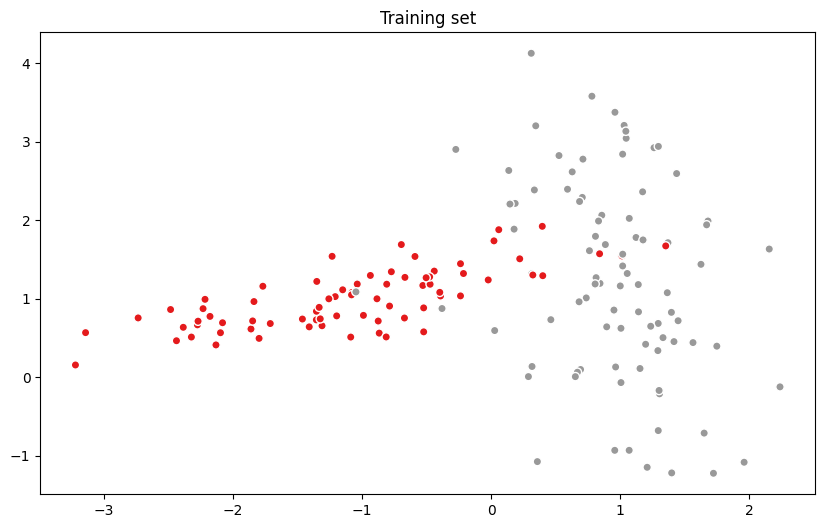

In [16]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# only for plotting
train_coords = X_train.T

plt.set_cmap("Set1")
plt.figure(figsize=(10, 6))
plt.title("Training set")
plt.scatter(train_coords[0], train_coords[1], c=y_train, ec="w")
plt.show()

Abbiamo quindi un training set e un test set su cui allenare e testare il
modello rispettivamente. Più precisamente non sfrutteremo la parte di test set
che ci fornisce la classe giusta per i punti classificati. Non è di nostro
interesse infatti testare la correttezza del modello.

Proseguiamo quindi con l'allenamento del modello e la classificazione dei nuovi
punti i quali diventeranno centrali nella nostra analisi.


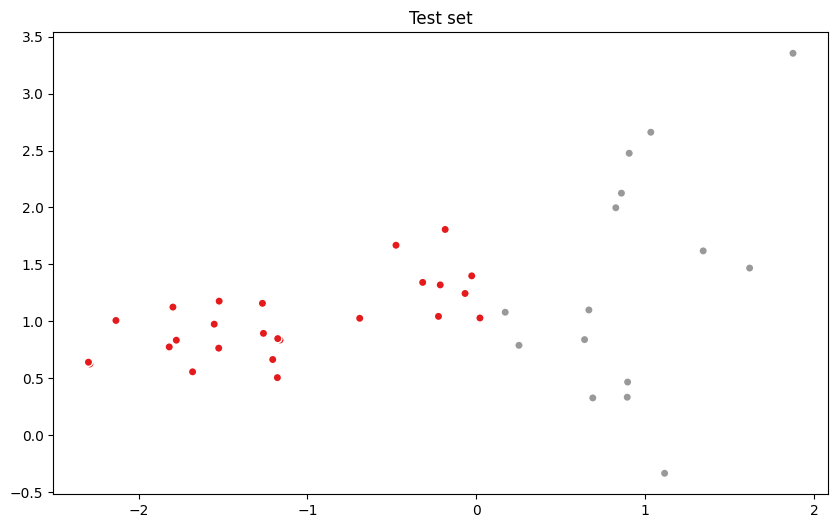

In [17]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier()
classifier.fit(X_train, y_train)
y_predicted = classifier.predict(X_test)

test_coords = X_test.T

plt.figure(figsize=(10, 6))
plt.title("Test set")
plt.scatter(test_coords[0], test_coords[1], c=y_predicted, ec="w")
plt.show()

A questo punto prendiamo a caso uno dei punti classificati, di seguito
evidenziato in verde


point: (0.17047, 1.08044)
class: 1


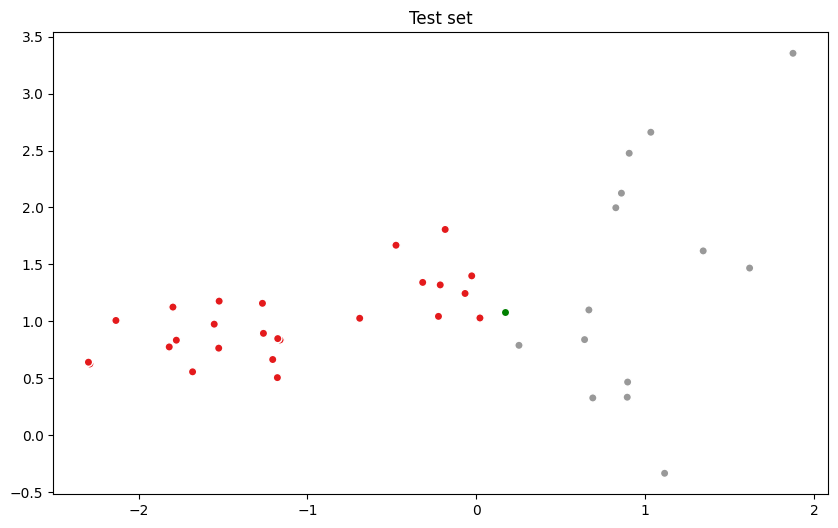

In [4]:
plt.figure(figsize=(10, 6))
plt.title("Test set")
plt.scatter(test_coords[0], test_coords[1], c=y_predicted, ec="w")

point = X_test[7]
print(f"point: ({point[0]:.5f}, {point[1]:.5f})")
point_class = y_predicted[7]
print(f"class: {point_class}")

plt.scatter(point[0], point[1], c="g", ec="w")
plt.show()

## Algoritmo genetico

L'algoritmo genetico prevede di analizzare ogni singolo punto un numero di
volte pari al numero delle classi possibili (nel nostro caso 2). Andremo a
definire due approcci volti a risolvere due problemi differenti:

1. Spiegare perché quel punto è stato classificato in un determinato modo.
2. Capire come modificare le feature di quel punto il meno possibile per
   riuscire a classificarlo in tutte le altre possibili classi.

Come forma del cromosoma abbiamo semplicemente il vettore delle feature di
ciascun individuo.

### Generazione della popolazione iniziale

Come in ogni algoritmo genetico c'è bisogno di andare a generare una
popolazione iniziale. Nel nostro caso abbiamo bisogno che la popolazione
iniziale sia generata in modo che i nuovi individui siano simili a quello di
riferimento.

Per riuscire a generare una popolazione con queste caratteristiche possiamo
sfruttare la deviazione standard di ogni feature per generare un offset
coerente con il dataset che stiamo considerando su ogni asse.


In [5]:
sigma = X_test.std(axis=0)
sigma

array([1.17144131, 0.6751292 ])

Per generare punti sintetici intorno a quello di riferimento usiamo due
possibili distribuzioni

- **Uniforme**: si ottiene una popolazione sintetica equamente distribuita su
  ogni asse sfruttando un parametro $\alpha \in [0, 1]$ per regolare l'ampiezza
  dell'intervallo di valori. Intervallo definito in funzione della deviazione
  standard di ognuna delle feature. Avremo quindi che per ogni feature, lo
  spazio entro cui vengono generate le feature dei punti sintetici è il
  seguente
  $$[x_i - \sigma_i \cdot \alpha, \; x_ i + \sigma_i \cdot \alpha]$$
  dove $x_i$ è il valore dell'$i$-esima feature per il punto $x$ e $\sigma_i$ è
  la deviazione standard dell'$i$-esima feature rispetto a tutta la popolazione.
- **Normale**: in modo simile possiamo usare una distribuzione normale centrata
  nel valore della feature e usare sempre una frazione della deviazione
  standard piccola a piacere. Avremo quindi una distribuzione del tipo:
  $$N(x_i, \; \sigma_i \cdot \alpha)$$
  in cui $x_i$ è il valore dell'$i$-esima feature e $\sigma_i$ la sua
  deviazione standard.

Una distribuzione normale dovrebbe avere il vantaggio di riuscire a scalare
con la stessa dispersione che ha popolazione intera, mantenendo le
caratteristiche delle distribuzione di punti iniziale.

Una distribuzione uniforme invece riempe uno spazio arbitrariamente grande e
ben definito intorno al punto di riferimento. Potrebbe però non rispecchiare
la distribuzione dei punti del dataset di riferimento. Lo spazio entro il quale
vengono generati i punti tenderà inoltre ad avere una forma rettangolare se si
genera un numero sufficiente di punti.


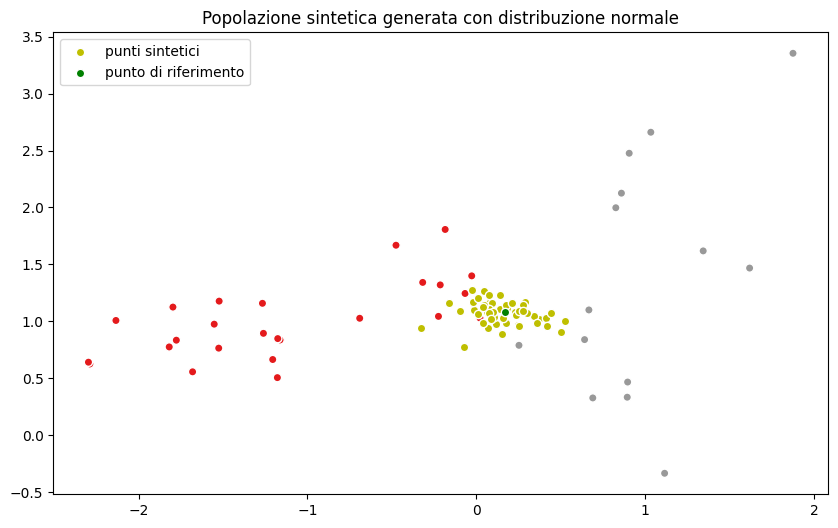

In [6]:
from numpy import random
from ppga import base


def generate_normal(point, sigma, alpha: float) -> np.ndarray:
    return random.normal(point, alpha * sigma, size=(2,))


def generate_uniform(point, sigma, alpha: float) -> np.ndarray:
    return random.uniform(point - sigma * alpha, point + sigma * alpha, size=(2,))


toolbox = base.ToolBox()
toolbox.set_generation(generate_normal, point=point, sigma=sigma, alpha=0.15)

# generazione di una popolazione composta da 50 individui
population = toolbox.generate(50)
synth_points = np.array([i.chromosome for i in population])

plt.figure(figsize=(10, 6))
plt.title("Popolazione sintetica generata con distribuzione normale")
plt.scatter(test_coords[0], test_coords[1], c=y_predicted, ec="w")
plt.scatter(
    synth_points.T[0], synth_points.T[1], c="y", ec="w", label="punti sintetici"
)
plt.scatter(point[0], point[1], c="g", ec="w", label="punto di riferimento")

plt.legend()
plt.show()

### Funzione di valutazione

La funzione di valutazione è certamente uno dei punti più importanti. Nello ci 
serviranno due funzioni differenti:

- La prima funzione ci serve nel caso in cui si voglia rimanere nella stessa
  classe del punto di riferimento.
- La seconda funzione ci serve invece quando si vuole cambiare la classe dei
  punti sintetici in una classe specifica, diversa da quella di partenza.

Il valore di fitness in sé viene invece dato dalla **distanza euclidea** tra i
due punti. Distanza che siamo sempre interessati a minimizzare. Ovviamente 
minimizzare la distanza e basta porterebbe tutti i punti a sovrapporsi
inevitabilmente al punto di partenza. Situazione decisamente poco informativa.

Per risolvere il problema è necessario implementare entrambe le funzioni in 
modo tale da far allontanare i punti sintetici dal punto d'origine fin tanto 
che non si verifica una certa condizione:

- Nel primo caso abbiamo funzione che fa allontanare i punti sintetici finché
  sono classificati come il punto di riferimento.
- Nel secondo caso abbiamo invece una funzione che fa allontanare i punti
  sintetici finché non sono classificati nella classe obbiettivo.

#### Stessa classe

L'obbiettivo della prima funzione di valutazione sarebbe quello di esplorare 
lo spazio circostante al punto, cercando di capire se ci siano confini di
classificazione vicini.

Quando un punto sintetico cambia classe, la funzione dovrebbe, invece che
allontanare ulteriormente il punto, riportarlo dentro il confine di
classificazione iniziale. In questo modo si dovrebbe mantenere il punto 
sintetico sul confine di classificazione.

Nel caso in cui un punto sia vicino a più confini di classificazione li si
potrebbe definire in un colpo solo senza però distinguere gli uni dagli altri.

#### Cambio di classe

Con la seconda funzione cerchiamo invece di esplorare lo spazio di lavoro alla
ricerca di un confine di classificazione specifico. Il comportamento è simile a
prima ma, mentre nel primo caso non abbiamo una preferenza per la direzione di 
espansione, in questo caso vogliamo muoverci in un modo più specifico verso una
classe target.

Muoversi in una direzione specifica non è tuttavia possibile. La funzione si 
occupa semplicemente di valutare meglio i punti classificati nella classe
target. Diventa quindi necessario che almeno uno dei punti sintetici arrivi
ad essere classificato in quest'ultima, affinché l'intera popolazione abbia un 
riferimento. Finché questo non accade ci si muove praticamente alla cieca nello
spazio di lavoro.

#### Criticità

Diventa quindi necessario definire una funzione di valutazione con un
comportamento diverso in base a come viene classificato il punto sintetico che
stiamo valutando.

L'obbiettivo sarebbe quello di andare a creare una sorta di effetto repulsivo
fin tanto che il punto sintetico viene classificato come quello d'origine, 
andando così ad esplorare lo spazio di lavoro. Per creare tale effetto abbiamo 
2 alternative semplici ed immediate: fin tanto che la classificazione è uguale

- Premiare i punti più lontani.
- Penalizzare i punti vicini in modo inversamente proporzionale alla loro
  distanza dal punto d'origine.

In entrambi i casi abbiamo un effetto di graduale allontanamento dal punto di 
partenza che tende a diminuire d'intensità man mano che ci si allontana.
Il potenziale problema di questo approccio è che la distanza dal punto di 
tende all'infinito se non si riesce a cambiare classe. Se per esempio un punto
viene generato più lontano dagli altri, tenderà a portarsi dietro il resto
della popolazione man mano che si allontana.

Per limitare questa situazione si potrebbe usare una funzione monotona
crescente con un limite finito per $x$ che tende all'infinto (per esempio una 
sigmoide). In questo modo si mantiene un comportamento simile a prima in cui
c'è un allontanamento graduale ma limitato.

#### Stessa classe

Vogliamo quindi allontanare i punti fin tanto che sono classificati nella
stessa classe del punto originale per poi riavvicinarli una volta cambiata la
classe per riportarli dentro al confine.

Vogliamo quindi una funzione di fitness che valuta i punti classificati come il 
punto di riferimento, tanto meglio quanto sono più lontani da esso. Al
contrario i punti classificati in una qualsiasi altra classe vengono premiati
con un valore di fitness tanto più alto quanto più piccola è la distanza con il
punto d'origine.

Ci dovrebbe poi essere una differenza abbastanza netta quando ci si trova al 
confine di modo da riportare dentro il boundary di classificazione i punti che 
hanno cambiato classe.

Una delle funzioni più banali e immediate potrebbe essere la seguente:

$$
f(x_i) = \begin{cases}
    \frac{1}{a \cdot d(x_0, x_i)} & \text{se } C_0 = C_i \\
    d(x_0, x_i) & \text{altrimenti}
\end{cases}
$$

dove $x_0$ e $C_0$ sono rispettivamente il vettore delle feature e la classe del
punto iniziale, mentre $x_i$ e $C_i$ sono rispettivamente le feature e la classe
dell'$i$-esimo punto sintetico.


In [7]:
from numpy import linalg


def same_evaluate(chromosome, point, classifier):
    # classification
    pt_class = classifier.predict(point.reshape(1, -1))
    synth_class = classifier.predict(chromosome.reshape(1, -1))

    # calcolo della distanza con norma euclidea
    distance = linalg.norm(point - chromosome, ord=2)
    same_class = 5.0 if pt_class == synth_class else 0.1

    return (same_class * distance,)


toolbox.set_weights((-1.0,))
toolbox.set_evaluation(same_evaluate, point, classifier)
population = list(map(toolbox.evaluate, population))

Andiamo quindi a vedere come sono stati classificati i punti sintetici e
di modo da capire come si è comportata la funzione di valutazione.


1


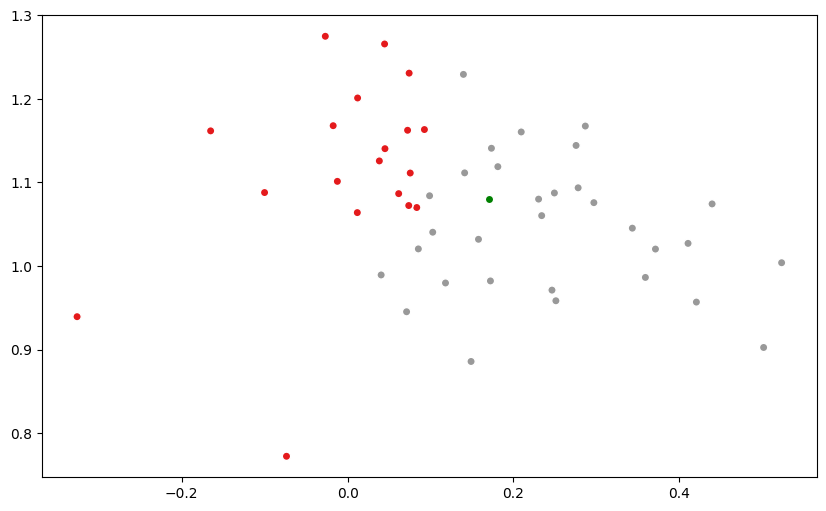

In [8]:
classes = [classifier.predict(i.chromosome.reshape(1, -1)) for i in population]
plt.figure(figsize=(10, 6))
plt.scatter(synth_points.T[0], synth_points.T[1], c=classes, ec="w")
plt.scatter(point[0], point[1], c="g", ec="w")
print(point_class)
plt.show()

Vediamo quindi come sono stati valutati in funzione della loro classificazione
e distanza dal punto d'origine.


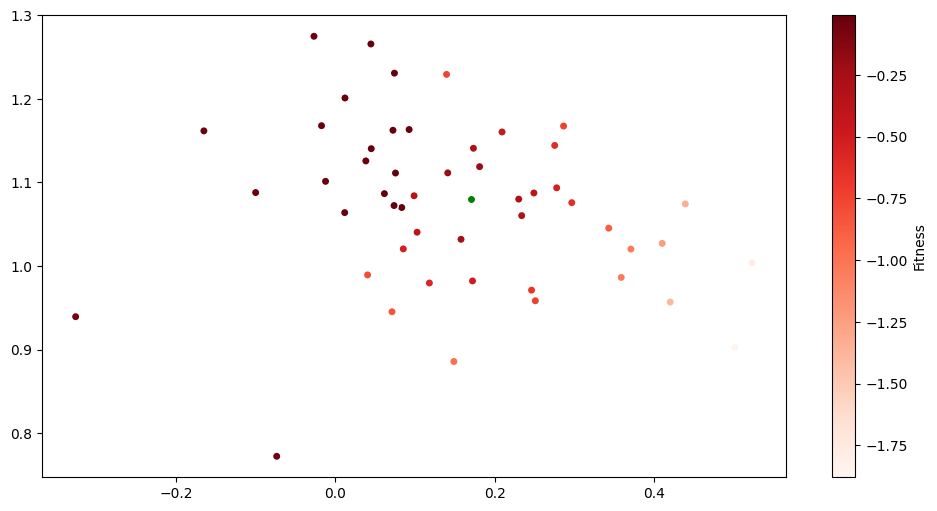

In [9]:
fitness_values = [i.fitness for i in population]
plt.figure(figsize=(12, 6))
sc = plt.scatter(
    synth_points.T[0],
    synth_points.T[1],
    c=fitness_values,
    ec="w",
    cmap=plt.get_cmap("Reds"),
)
plt.colorbar(sc, label="Fitness")
plt.scatter(point[0], point[1], c="g", ec="w")
plt.show()

#### Cambio di classe

Andiamo ora a costruire una funzione di fitness di modo da premiare gli
individui che riescono ad essere classificati in una classe target differente
da quella di partenza.

In questo caso abbiamo una funzione con un comportamento leggermente differente:

$$
f(x_i) = \begin{cases}
    1 - d(x_0, x_i) & \text{se } C_i \neq C_t \\
    d(x_0, x_i) & \text{altrimenti}
\end{cases}
$$

dove $C_t$ è la classe target a cui stiamo cercando di arrivare.


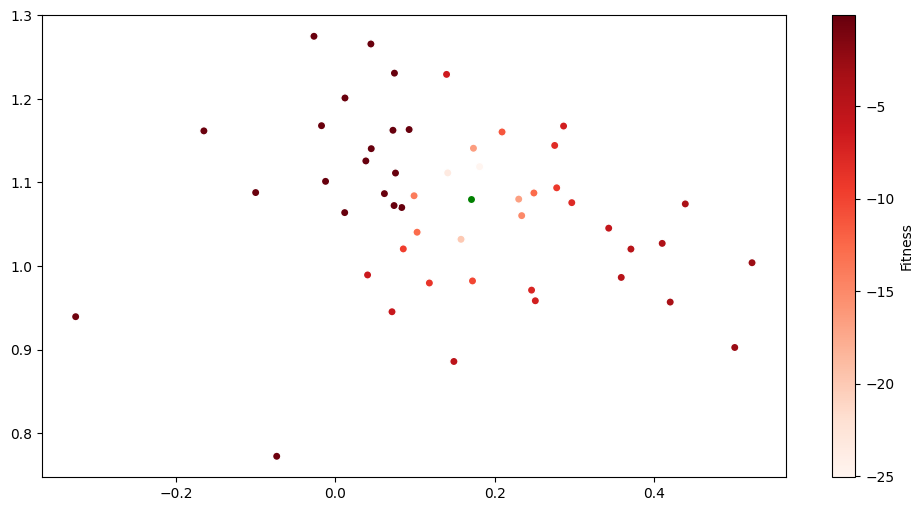

In [10]:
def other_evaluate(chromosome, point, classifier, target):
    # classification
    synth_class = classifier.predict(chromosome.reshape(1, -1))

    # calcolo della distanza con norma euclidea
    distance = linalg.norm(point - chromosome, ord=2)

    if target == synth_class:
        return (distance,)
    else:
        return (1 / distance,)


toolbox.set_weights((-1.0,))
toolbox.set_evaluation(other_evaluate, point, classifier, (point_class + 1) % 2)
population = list(map(toolbox.evaluate, population))

fitness_values = [i.fitness for i in population]
plt.figure(figsize=(12, 6))
sc = plt.scatter(
    synth_points.T[0],
    synth_points.T[1],
    c=fitness_values,
    ec="w",
    cmap=plt.get_cmap("Reds"),
)
plt.colorbar(sc, label="Fitness")
plt.scatter(point[0], point[1], c="g", ec="w")
plt.show()

### Crossover

Gli operatori di crossover da testare sono principalmente due:

- **One point** o **Two Points**: questi due operatori andrebbero a mischiare
  le feature dei due individui lasciandole invariate, sarà poi compito
  dell'operatore di mutazione effettuare variazioni sui valori stessi.
- **Media e fattore stocastico**: in alternativa si potrebbero creare due figli
  le cui feature sono la media delle feature dei genitori. Dato che sarebbero
  due figli uguali si potrebbe aggiungere un termine casuale per differenziarli.
  In alternativa si potrebbe generare un solo figlio da ogni coppia.

Per i test andremo ad usare un semplice _one point crossover_.


In [11]:
def cx_one_point(father, mother):
    cx_point = random.randint(1, len(father))

    offspring1 = np.append(father[:cx_point], mother[cx_point:])
    offspring2 = np.append(mother[:cx_point], father[cx_point:])

    return offspring1, offspring2


toolbox.set_crossover(cx_one_point)
o1, o2 = toolbox.crossover(population[0], population[1])
print(f"father: {population[0].chromosome}")
print(f"mother: {population[1].chromosome}")
print(f"offspring 1: {o1.chromosome}")
print(f"offspring 2: {o2.chromosome}")

father: [-0.01229129  1.10131995]
mother: [0.37118417 1.02029637]
offspring 1: [-0.01229129  1.02029637]
offspring 2: [0.37118417 1.10131995]


Come possiamo vedere con due features andiamo semplicemente ad incrociare i
valori di padre e madre per generare due figli. Il problema di questo crossover
è che da solo non genera mai nuovi valori per le feature ma va ad esplorare
le possibili permutazioni dei valori già esistenti.

### Mutazione

L'operatore di mutazione andrà a modificare ogni feature di un termine
stocastico con una certa probabilità. Tale termine viene generato casualmente
tramite una distribuzione gaussiana
$$N(x_i, \; \alpha \cdot \sigma_i)$$
centrata nel valore della feature $i$-esima ($x_i$) e con deviazione standard
una frazione ($\alpha$) della deviazione standard di quella feature calcolata
sull'intera popolazione ($\sigma_i$).


In [12]:
def mut_gaussian(individual, sigma, alpha: float = 0.05, indpb: float = 0.2):
    for i, f in enumerate(individual):
        if random.random() <= indpb:
            individual[i] = random.normal(loc=f, scale=sigma[i] * alpha)

    return individual


toolbox.set_mutation(mut_gaussian, sigma, 0.1, 0.8)
print(o1)
o1 = toolbox.mutate(o1)
print(o1)

[-0.01229129  1.02029637]: 0.0
[-0.22288624  1.09210156]: 0.0


L'operatore richiede quindi la deviazione standard di tutte le feature calcolata
sull'intera popolazione, un parametro $\alpha$ che regola l'intesità della
mutazione e la probabilità che ogni singola feature ha di essere mutata.


### Simulazione

Proviamo quindi ad effettuare una simulazione provando a capire quale sia il
modo migliore di far cambiare classe al punto in questione.

Di seguito è possibile vedere la i migliori individui della popolazione
sintetica finale, tutti raccolti nella _Hall of Fame_ generazione dopo
generazione.


generations: 100%|██████████████████████████████| 50/50 [00:10<00:00,  4.63it/s]


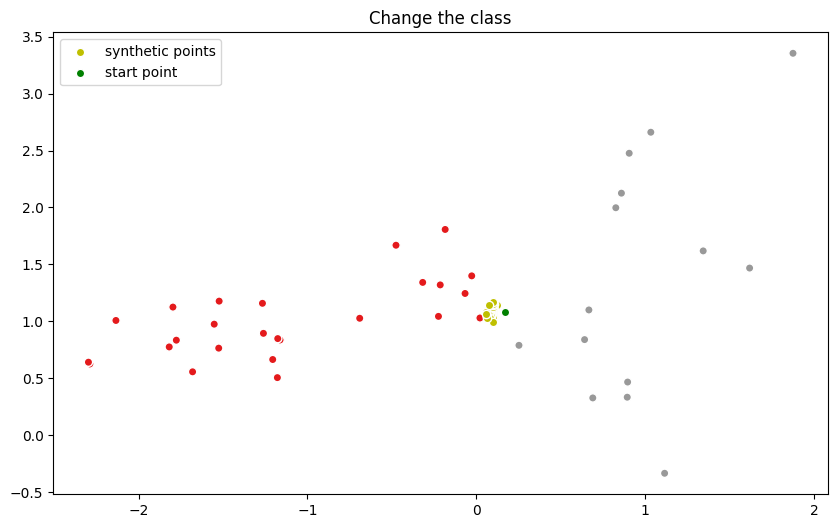

In [13]:
from ppga import tools, algorithms

toolbox.set_selection(tools.sel_ranking)
toolbox.set_replacement(tools.merge)

hof = base.HallOfFame(50)
population, stats = algorithms.psga(toolbox, 50, 0.8, 0.2, 50, hof)

synth_points = np.array([i.chromosome for i in hof])

plt.figure(figsize=(10, 6))
plt.title("Change the class")
plt.scatter(test_coords[0], test_coords[1], c=y_predicted, ec="w")
plt.scatter(
    synth_points.T[0], synth_points.T[1], c="y", ec="w", label="synthetic points"
)
plt.scatter(point[0], point[1], c="g", ec="w", label="start point")

plt.legend()
plt.show()

Come si può vedere, i punti sintetici si schiacciano sul confine tra una classe
e l'altra.

### Analisi

Il prossimo passo è quello di andare a comparare le feature del punto originale
con quelle dei punti sintetici che sono riusciti a cambiare classe. In questo
modo è possibile _spiegare_ come far cambiare classe ad un determinato punto.


In [14]:
hof = list(
    filter(
        lambda x: classifier.predict(x.chromosome.reshape(1, -1)) != point_class,
        hof.hof,
    )
)
print(f"best synth points: {len(hof)}")
for i in hof:
    print(f"{i} | class: {classifier.predict(i.chromosome.reshape(1, -1))}")

d1 = linalg.norm(hof[-1].chromosome[0] - point[0])
d2 = linalg.norm(hof[-1].chromosome[1] - point[1])

best synth points: 40
[0.0985633  1.08025274]: -0.07191130633592613 | class: [0]
[0.0985633 1.076112 ]: -0.07204090815937556 | class: [0]
[0.09827776 1.08025274]: -0.07219684990883395 | class: [0]
[0.09827776 1.08022172]: -0.07219693495303282 | class: [0]
[0.09827776 1.08195222]: -0.07221255650738315 | class: [0]
[0.09827776 1.08211704]: -0.0722162071280882 | class: [0]
[0.09827776 1.08434463]: -0.0723023911309094 | class: [0]
[0.09827776 1.07628674]: -0.07231570544263348 | class: [0]
[0.09827776 1.06905349]: -0.07308826375080238 | class: [0]
[0.09625028 1.08434463]: -0.07432698017605728 | class: [0]
[0.09618047 1.06905349]: -0.07516067657679615 | class: [0]
[0.09827776 1.05690521]: -0.07593425254039346 | class: [0]
[0.09827776 1.10778617]: -0.07720381585109252 | class: [0]
[0.09625028 1.05690521]: -0.07786446511543797 | class: [0]
[0.09618047 1.05690521]: -0.07793101894780506 | class: [0]
[0.09827776 1.11331583]: -0.07933151960839047 | class: [0]
[0.09827776 1.11550687]: -0.0802644167

In [15]:
print(d1)
print(d2)

0.09793110103351055
0.0663229138509136
